In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#pd.set_option('display.max_rows', None)

In [2]:
from collections import Counter
import arabic_reshaper 
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from wordcloud import WordCloud, ImageColorGenerator
from langdetect import detect
from nltk.corpus import stopwords
import re
import nltk
from transformers import pipeline
from scipy.stats import zscore

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-23 22:35:41.401138: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Channels

In [150]:
df_channels = pd.read_csv('Fetched-Data/channel_stats.txt', index_col=0)
df_channels.head()

,id,name,description,total_videos,nb_subscribers,nb_views,playlist_id,country,defaultLanguage,topicCategories,date_published,time_published,topics,del,detectedLanguage,audio_language,selected_language
1,UCBFV7W4f1kRgwUf3pCWWlQg,SFSU Department of Criminal Justice Studies,NaN,12,30,2850,UUBFV7W4f1kRgwUf3pCWWlQg,NaN,NaN,"['https://en.wikipedia.org/wiki/Knowledge', 'h...",2020-06-09,19:00:22,"['Knowledge', 'Society']",No,en,en-US,en-US
2,UCImlTJDmo1hn1EDgohNM37g,Red Stories | قصص ريد,Red Stories |قصص ريد\nنشر قصص واقعيه .. \n,543,88000,484371,UUImlTJDmo1hn1EDgohNM37g,SA,ar,['https://en.wikipedia.org/wiki/Society'],2015-01-18,13:13:10,['Society'],No,ar,zxx,zxx
5,UCUclZUo5F1IuBhBqHeKot8g,Criminal,NaN,5,3,189,UUUclZUo5F1IuBhBqHeKot8g,NaN,NaN,NaN,2024-05-13,08:37:03,NaN,NaN,it,NaN,it
6,UCvxnZzQz_BuNEzR1qCMNpMQ,MIRROR POST,आईना सच का...,698,4110,1497261,UUvxnZzQz_BuNEzR1qCMNpMQ,IN,NaN,"['https://en.wikipedia.org/wiki/Politics', 'ht...",2023-01-03,12:28:52,"['Politics', 'Society']",No,hi,NaN,hi
7,UCniLwK5vDjEvEa0ZRnlahMg,ATTENTAT AGRESSION CHAUFEUR VTC,NaN,1,1,706,UUniLwK5vDjEvEa0ZRnlahMg,NaN,NaN,NaN,2015-12-26,19:13:49,NaN,NaN,en,NaN,en


In [151]:
df_channel = df_channels.drop(['defaultLanguage','topicCategories','del','detectedLanguage','audio_language'], axis=1)
df_channel.columns

Index(['id', 'name', 'description', 'total_videos', 'nb_subscribers',
       'nb_views', 'playlist_id', 'country', 'date_published',
       'time_published', 'topics', 'selected_language'],
      dtype='object')

In [152]:
df_channel.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1646 entries, 1 to 3625
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1646 non-null   object
 1   name               1646 non-null   object
 2   description        1078 non-null   object
 3   total_videos       1646 non-null   int64 
 4   nb_subscribers     1646 non-null   int64 
 5   nb_views           1646 non-null   int64 
 6   playlist_id        1646 non-null   object
 7   country            747 non-null    object
 8   date_published     1646 non-null   object
 9   time_published     1646 non-null   object
 10  topics             947 non-null    object
 11  selected_language  1645 non-null   object
dtypes: int64(3), object(9)
memory usage: 167.2+ KB


In [153]:
df_channel.describe()

,total_videos,nb_subscribers,nb_views
count,1646.000000,1.646000e+03,1.646000e+03
mean,551.572904,1.212919e+05,2.963601e+07
std,4706.472605,8.892694e+05,3.825481e+08
min,1.000000,0.000000e+00,0.000000e+00
25%,1.000000,3.000000e+00,6.400000e+01
50%,11.000000,9.000000e+01,4.918000e+03
75%,111.750000,2.565000e+03,2.634795e+05
max,122412.000000,2.540000e+07,1.345365e+10


**Clean the selected_language column**

In [ ]:
# Process the 'selected_language' column
df_channel['selected_language'] = (
    df_channel['selected_language']
    .str.split('-')
    .str[0]  # Get the part before the hyphen
    .str.lower()  # Convert to lowercase
)

df_channel.dropna(subset=['selected_language'], inplace=True)
df_channel['selected_language'].value_counts().reset_index(drop=False)

**Adding the full names of coutries**

In [177]:
# Mapping dictionary
country_mapping = {
    'MY': 'Malaysia',
    'MA': 'Morocco',
    'UA': 'Ukraine',
    'CZ': 'Czech Republic',
    'GT': 'Guatemala',
    'TR': 'Turkey',
    'KE': 'Kenya',
    'RU': 'Russia',
    'KW': 'Kuwait',
    'AE': 'United Arab Emirates',
    'PE': 'Peru',
    'PH': 'Philippines',
    'PT': 'Portugal',
    'SA': 'Saudi Arabia',
    'HK': 'Hong Kong',
    'TW': 'Taiwan',
    'ZW': 'Zimbabwe',
    'SN': 'Senegal',
    'IT': 'Italy',
    'GB': 'United Kingdom',
    'GH': 'Ghana',
    'BE': 'Belgium',
    'TN': 'Tunisia',
    'ES': 'Spain',
    'AU': 'Australia',
    'JP': 'Japan',
    'SG': 'Singapore',
    'LB': 'Lebanon',
    'PK': 'Pakistan',
    'JO': 'Jordan',
    'BD': 'Bangladesh',
    'OM': 'Oman',
    'IN': 'India',
    'BR': 'Brazil',
    'CH': 'Switzerland',
    'IQ': 'Iraq',
    'GR': 'Greece',
    'NL': 'Netherlands',
    'CA': 'Canada',
    'NP': 'Nepal',
    'CO': 'Colombia',
    'FR': 'France',
    'CI': 'Ivory Coast',
    'DE': 'Germany',
    'US': 'United States',
    'DZ': 'Algeria',
    'IE': 'Ireland',
    'EG': 'Egypt',
    'ZA': 'South Africa',
    'YE': 'Yemen',
    'TH': 'Thailand',
    'KR': 'South Korea'
}


# Create a new column with the full country names
df_channel['country_full'] = df_channel['country'].map(country_mapping)

# Display the updated DataFrame
df_channel.head()


,id,name,description,total_videos,nb_subscribers,nb_views,playlist_id,country,date_published,time_published,topics,selected_language,country_full
1,UCBFV7W4f1kRgwUf3pCWWlQg,SFSU Department of Criminal Justice Studies,NaN,12,30,2850,UUBFV7W4f1kRgwUf3pCWWlQg,NaN,2020-06-09,19:00:22,"['Knowledge', 'Society']",en,NaN
2,UCImlTJDmo1hn1EDgohNM37g,Red Stories | قصص ريد,Red Stories |قصص ريد\nنشر قصص واقعيه .. \n,543,88000,484371,UUImlTJDmo1hn1EDgohNM37g,SA,2015-01-18,13:13:10,['Society'],zxx,Saudi Arabia
5,UCUclZUo5F1IuBhBqHeKot8g,Criminal,NaN,5,3,189,UUUclZUo5F1IuBhBqHeKot8g,NaN,2024-05-13,08:37:03,NaN,it,NaN
6,UCvxnZzQz_BuNEzR1qCMNpMQ,MIRROR POST,आईना सच का...,698,4110,1497261,UUvxnZzQz_BuNEzR1qCMNpMQ,IN,2023-01-03,12:28:52,"['Politics', 'Society']",hi,India
7,UCniLwK5vDjEvEa0ZRnlahMg,ATTENTAT AGRESSION CHAUFEUR VTC,NaN,1,1,706,UUniLwK5vDjEvEa0ZRnlahMg,NaN,2015-12-26,19:13:49,NaN,en,NaN


**Channel Growth Analysis**

Total Videos vs. Subscribers: Analyze how the number of videos correlates with subscriber count.

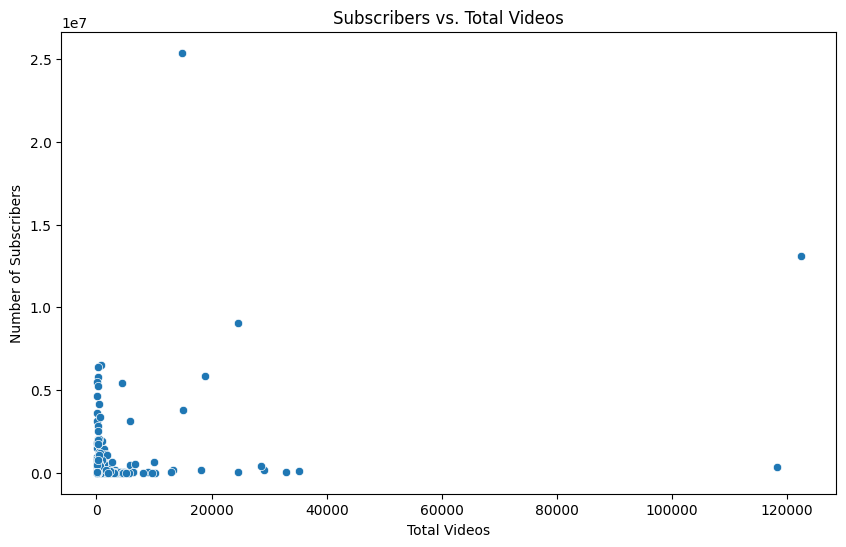

In [156]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_videos', y='nb_subscribers', data=df_channel)
plt.title('Subscribers vs. Total Videos')
plt.xlabel('Total Videos')
plt.ylabel('Number of Subscribers')
plt.show()


**Country Analysis**

Geographical Distribution: Analyze the distribution of channels across different countries when available (747 missing values).

/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/1443298692.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')


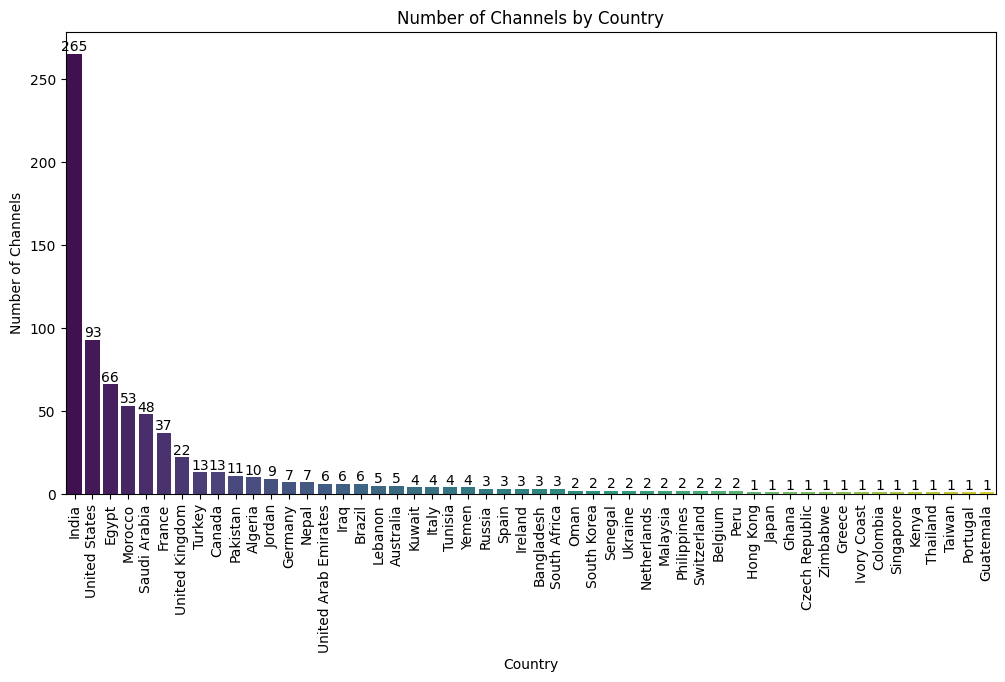

In [178]:
# Count the number of channels per country
country_counts = df_channel['country_full'].value_counts()

# Create the bar plot
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x=country_counts.index, y=country_counts.values, palette='viridis')

# Adding value labels on top of the bars
for p in bar_plot.patches:
    bar_plot.annotate(format(p.get_height(), '.0f'),  # Format the height as an integer
                      (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the label
                      ha='center', va='bottom', fontsize=10)  # Adjust label position and font size

# Set the title and labels
plt.title('Number of Channels by Country')
plt.xlabel('Country')
plt.ylabel('Number of Channels')
plt.xticks(rotation=90)

# Show the plot
plt.show()


**Language Analysis**

Language Preferences: Analyze how selected languages correlate with the number of subscribers or views.

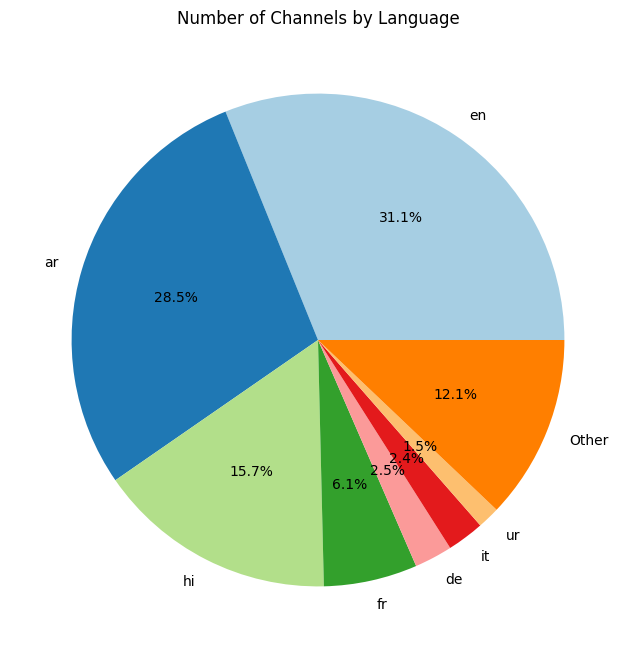

In [180]:
# Count of languages used by channels
language_counts = df_channel['selected_language'].value_counts()

# Select the top 10 languages
top_languages = language_counts[:7]

# Group the rest into 'Other'
top_languages['Other'] = language_counts[7:].sum()

# Plotting
plt.figure(figsize=(8, 8))
plt.pie(top_languages, labels=top_languages.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Percentage of Channels by Language')
plt.show()



/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/2396029243.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Language', data=top_languages, palette=color, ax=ax)
/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/2396029243.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Language', data=top_languages, palette=color, ax=ax)
/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/2396029243.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metric, y='Language', data=to

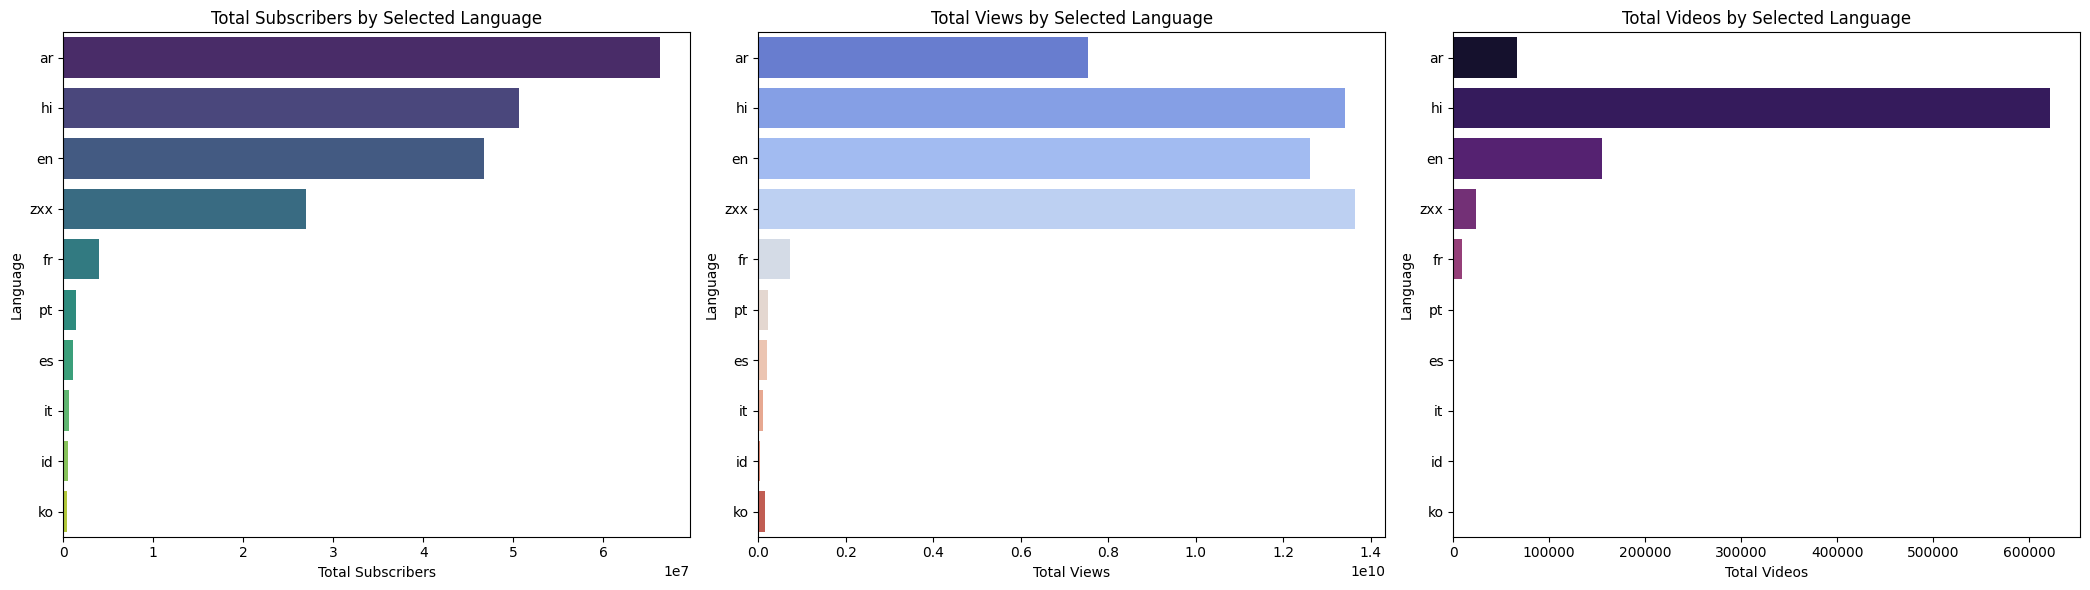

In [185]:
# Group by selected language and calculate the total subscribers, views, and total videos
language_metrics = df_channel.groupby('selected_language').agg({
    'id': 'count',  # How many channels per language
    'nb_subscribers': 'sum',
    'nb_views': 'sum',
    'total_videos': 'sum'
}).reset_index()

# Rename columns for clarity
language_metrics.columns = ['Language', 'Number of Channels', 'Total Subscribers', 'Total Views', 'Total Videos']

# Sort by Total Subscribers and get the top 10 languages
top_languages = language_metrics.sort_values('Total Subscribers', ascending=False).head(10)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# Define the metrics and titles for the subplots
metrics = ['Total Subscribers', 'Total Views', 'Total Videos']
titles = ['Total Subscribers by Selected Language', 'Total Views by Selected Language', 'Total Videos by Selected Language']
colors = ['viridis', 'coolwarm', 'magma']

# Loop through the metrics to create the subplots
for ax, metric, title, color in zip(axes, metrics, titles, colors):
    sns.barplot(x=metric, y='Language', data=top_languages, palette=color, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(metric)
    ax.set_ylabel('Language')

# Adjust layout
plt.tight_layout()
plt.show()


**Temporal Analysis**

Growth Over Time: Analyze how the number of channels has grown over time based on date_published.

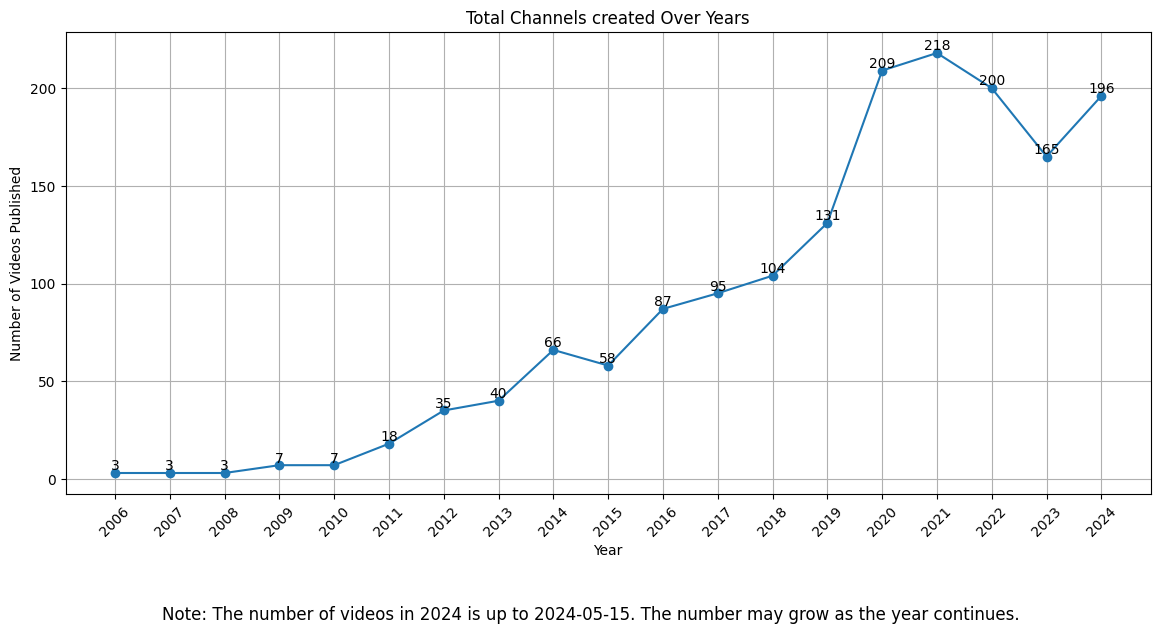

In [192]:
df_channel['date_published'] = pd.to_datetime(df_channel['date_published'])
df_channel['year'] = df_channel['date_published'].dt.year
yearly_growth = df_channel.groupby('year')['id'].count().reset_index()
yearly_growth.columns=['year','nb_channels']

# Find the last date in the DataFrame
last_date = df_channel['date_published'].max()

# Create the comment about 2024
comment = f"Note: The number of videos in 2024 is up to {last_date.date()}. The number may grow as the year continues."

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(yearly_growth['year'], yearly_growth['nb_channels'], marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Videos Published')
plt.title('Total Channels created each Year')
plt.grid(True)
plt.xticks(yearly_growth['year'], rotation=45)

# Add values on the plot
for x, y in zip(yearly_growth['year'], yearly_growth['nb_channels']):
    plt.text(x, y, str(y), ha='center', va='bottom')

# Add the comment to the plot
plt.figtext(0.5, -0.1, comment, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


**Correlations and Relationships**

Correlation Matrix: Analyze the correlation between numeric features to see relationships.

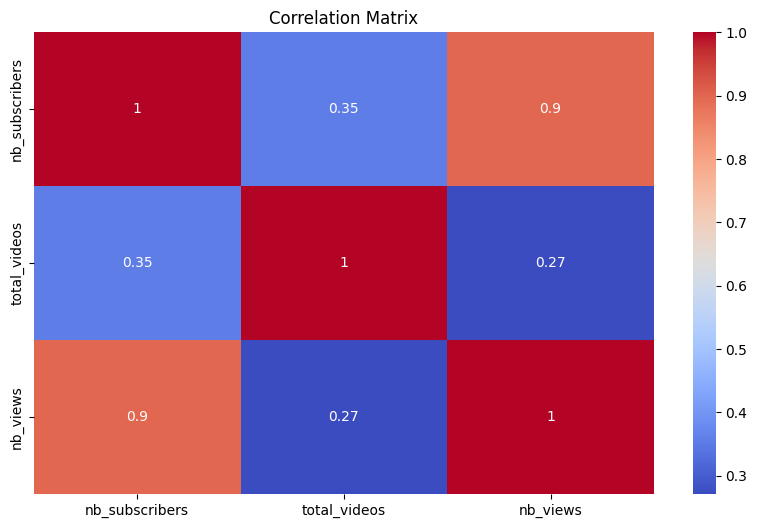

In [196]:
correlation_matrix = df_channel[['nb_subscribers','total_videos','nb_views']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


**Top Channels Analysis**

Identify channels with the most subscribers and views

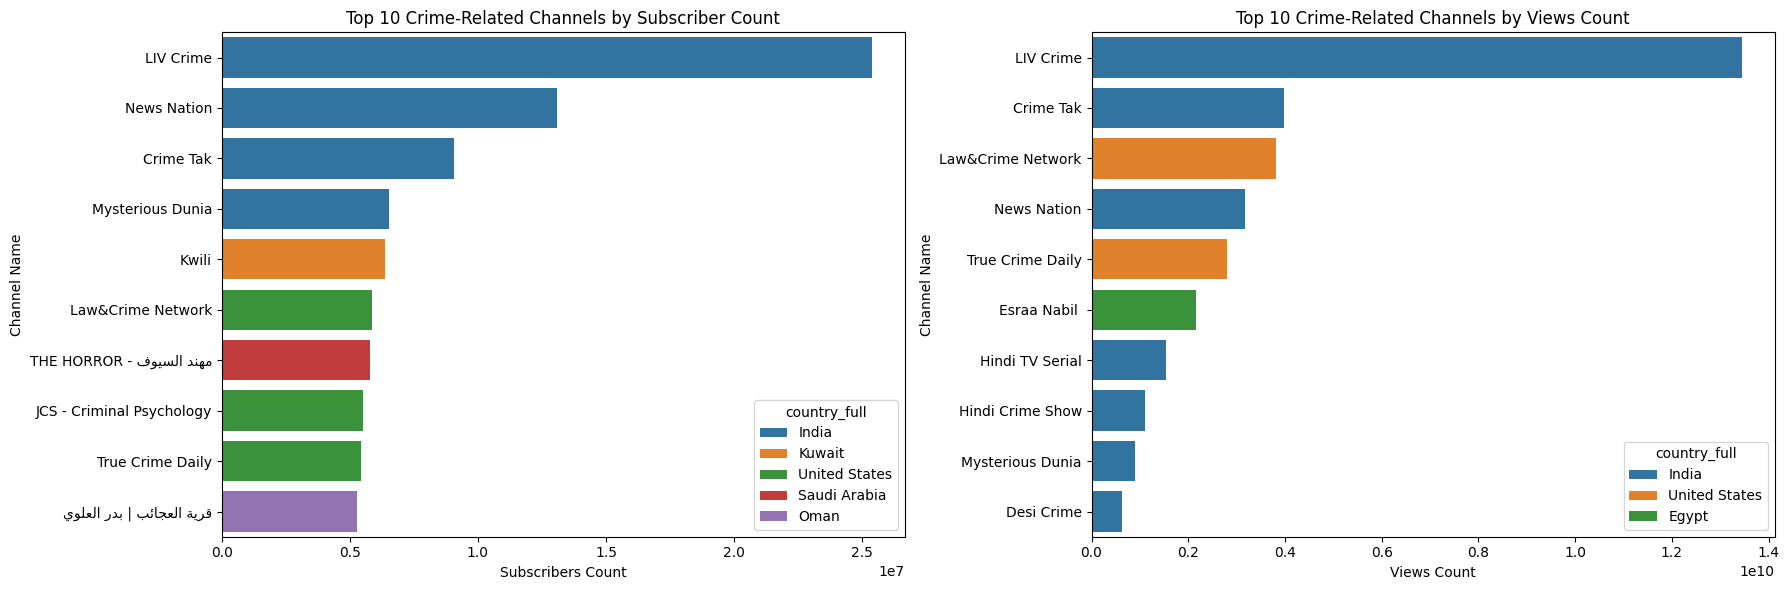

In [210]:
# Function to reshape and correctly display Arabic text
def process_arabic_text(text):
    try:
        reshaped_text = reshape(text)  # Reshape the Arabic text
        return get_display(reshaped_text)  # Correct the text direction to RTL
    except:
        return text  # Return the original text if any errors occur

# Top 10 channels by subscriber count
top_channels_subscribers = df_channel.sort_values('nb_subscribers', ascending=False).head(10)

# Top 10 channels by view count
top_channels_views = df_channel.sort_values('nb_views', ascending=False).head(10)

# Apply processing to channel names to handle Arabic properly
top_channels_subscribers['display_name'] = top_channels_subscribers['name'].apply(process_arabic_text)
top_channels_views['display_name'] = top_channels_views['name'].apply(process_arabic_text)

# One channel has no Country so I'm adding it manually after checking it from India
top_channels_views.fillna('India', inplace=True)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plotting subscribers
sns.barplot(x='nb_subscribers', y='display_name', data=top_channels_subscribers, ax=axes[0], hue='country_full')
axes[0].set_xlabel('Subscribers Count')
axes[0].set_ylabel('Channel Name')
axes[0].set_title('Top 10 Crime-Related Channels by Subscriber Count')

# Plotting views
sns.barplot(x='nb_views', y='display_name', data=top_channels_views, ax=axes[1], hue='country_full')
axes[1].set_xlabel('Views Count')
axes[1].set_ylabel('Channel Name')
axes[1].set_title('Top 10 Crime-Related Channels by Views Count')


# Adjust layout
plt.tight_layout()
plt.show()


**Calculate Z-scores for Outlier Detection**

Use Z-scores to detect Channels with unusually high or low views

In [212]:
from scipy.stats import zscore

# Calculate z-scores for the view count to identify outliers
df_channel['view_zscore'] = zscore(df_channel['nb_views'])
# Identify outliers where z-score is beyond a typical threshold, e.g., > 3 or < -3
outliers = df_channel[(df_channel['view_zscore'] > 3) | (df_channel['view_zscore'] < -3)]
outliers[['name', 'nb_views', 'view_zscore']].sort_values(['view_zscore'], ascending=False)

,name,nb_views,view_zscore
3392,LIV Crime,13453654141,35.091078
163,Crime Tak,3973510942,10.309460
2418,Law&Crime Network,3818816833,9.905081
2706,News Nation,3169472857,8.207660
3403,True Crime Daily,2802994635,7.249666
58,Esraa Nabil,2159853209,5.568458
1553,Hindi TV Serial,1548978560,3.971598


**Channel Engagement Analysis**

Analyze the relationship between the number of subscribers and average views per video, and identify channels with high engagement despite low subscriber counts.

In [256]:
# Calculate average views per video
df_channel['avg_views'] = df_channel['nb_views'] / df_channel['total_videos']
channel_engagement = df_channel[['id', 'name','avg_views','nb_subscribers']]

# Calculate engagement ratio
channel_engagement['engagement_ratio'] = channel_engagement['avg_views'] / channel_engagement['nb_subscribers']
threshold_value = channel_engagement['engagement_ratio'].quantile(0.75)
high_engagement_channels = channel_engagement[channel_engagement['engagement_ratio'] > threshold_value]  
high_engagement_channels


/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/3829989770.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  channel_engagement['engagement_ratio'] = channel_engagement['avg_views'] / channel_engagement['nb_subscribers']


,id,name,avg_views,nb_subscribers,engagement_ratio
7,UCniLwK5vDjEvEa0ZRnlahMg,ATTENTAT AGRESSION CHAUFEUR VTC,706.000,1,706.000000
28,UCdSnRgeDYOtZ8EwojYUYOkA,جرائم حول العالم,2.000,0,inf
32,UCLJJcygtI8co-XNVaHDXVCw,EKY Cold Case,1542.500,46,33.532609
50,UCd4RFoDeKZLkVGy3_C1X4BA,CALACS Agression Estrie,130.000,1,130.000000
56,UCt4J3j3RMoPgAny0eVQgyhg,Cold case,20.000,0,inf
...,...,...,...,...,...
3558,UCO4C-d89i2L6jWEFH-0SN8Q,Bhakti Sansar,2.500,0,inf
3561,UCItaxmxKUsJXLv5TEViD-Hw,Enquêtes criminels,166.625,7,23.803571
3582,UChiAfMHWTmVnzhYlCev24KQ,All players 2.0 editor,2.000,0,inf
3588,UCAOo7bTFIPErA_GrIUyGKKQ,Criminal Holiday - Topic,266.000,7,38.000000


/var/folders/v3/vzv7hgws4w50m44vnrtb6py80000gn/T/ipykernel_4427/2536832367.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


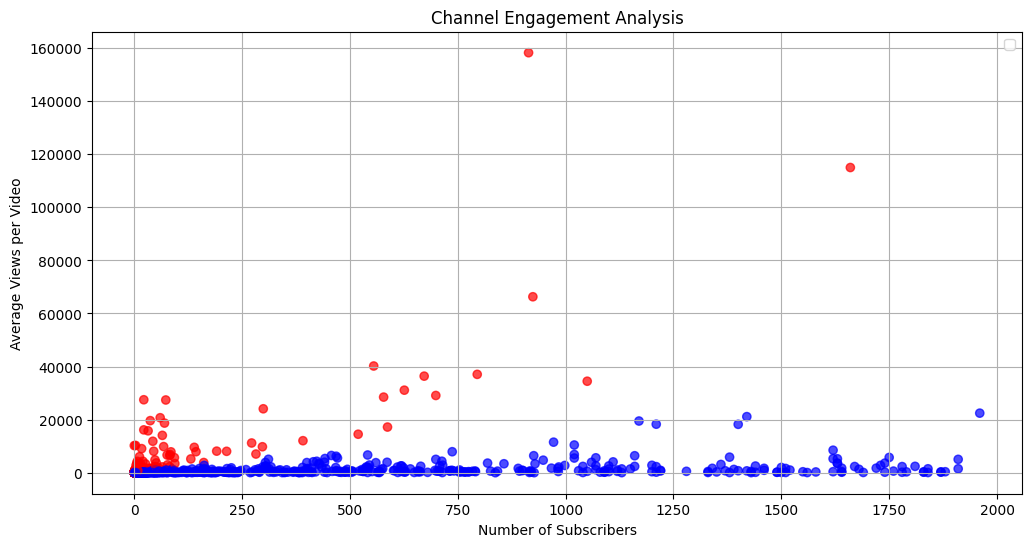

In [261]:
# keep channels with low number of subscribers
channel_engagement = channel_engagement[channel_engagement['nb_subscribers']<2000]

# Define colors for plotting
colors = ['red' if x > threshold_value else 'blue' for x in channel_engagement['engagement_ratio']]

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(channel_engagement['nb_subscribers'], channel_engagement['avg_views'], c=colors, alpha=0.7)
plt.xlabel('Number of Subscribers')
plt.ylabel('Average Views per Video')
plt.title('Channel Engagement Analysis')
#plt.axhline(y=threshold_value, color='gray', linestyle='--', label='Engagement Threshold')
plt.legend()
plt.grid(True)
plt.show()